## Development Work in the utterance-embeddings branch
* 'Home' notebook for initial development of using utterance embeddings (rather than speaker embeddings) in a basic VoiceLoop architecture
* Starting with VCTK-22 because it should train much faster (although there's less diversity across the speakers)

In [1]:
# needs to run in the fader-networks branch
# (that's also where all the checkpoints are)
import os
os.chdir('/home/ubuntu/msc-project-utterance-embeddings/')

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm

from model import Loop, MaskedMSE

from utils import generate_merlin_wav, wrap

from data import NpzFolder, NpzLoader

import notebook_utils as nu

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

import sklearn.metrics.pairwise as pw

from IPython.display import Audio
import IPython.display

%matplotlib inline

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
import training_monitor as tm
import eval_curves as ec

In [5]:
os.getcwd()

'/home/ubuntu/msc-project-utterance-embeddings'

### 1) Initial dev: just getting it to work at all

```python
python train.py --expName='vctk-us-utterance' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22
```

In [7]:
tm_base = tm.TrainingMonitor('vctk-us-utterance.csv', exp_name='vctk-us-utteranc', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [8]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,1,31-Jul-2018 18:48:17,51.348920,51.078694,NaN
1,2,31-Jul-2018 18:54:24,47.056820,47.163835,NaN
2,3,31-Jul-2018 19:00:27,44.850312,45.275831,NaN
3,4,31-Jul-2018 19:06:30,44.065964,44.515912,NaN
4,5,31-Jul-2018 19:12:30,44.649932,44.945066,NaN
5,6,31-Jul-2018 19:18:26,44.339509,44.172542,NaN
6,7,31-Jul-2018 19:24:19,43.276092,43.719590,NaN
7,8,31-Jul-2018 19:30:09,43.396621,43.377975,NaN
8,9,31-Jul-2018 19:35:57,43.345080,43.571040,NaN
9,10,31-Jul-2018 19:41:55,42.653292,42.971695,NaN


##### After tweaking the code to do a single conv-based embedding for each utterance, rather than a conv+RNN embedding that updates at each step along the TBPTT sequence

```python
python train.py --expName='vctk-us-utterance-fullfeat' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22
```

In [249]:
tm_base = tm.TrainingMonitor('vctk-us-utterance-fullfeat.csv', exp_name='vctk-us-utterance-fullfeat', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [250]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,1,01-Aug-2018 08:31:07,50.780958,51.318836,NaN
1,2,01-Aug-2018 08:39:22,46.189427,46.483465,NaN
2,3,01-Aug-2018 08:47:36,44.485311,44.571792,NaN
3,4,01-Aug-2018 08:55:50,43.344818,43.426585,NaN
4,5,01-Aug-2018 09:03:58,42.963607,43.052429,NaN
5,6,01-Aug-2018 09:12:11,42.351012,42.405604,NaN
6,7,01-Aug-2018 09:20:17,41.728229,41.927961,NaN
7,8,01-Aug-2018 09:28:28,41.744975,41.807030,NaN
8,9,01-Aug-2018 09:36:35,40.894942,41.109198,NaN
9,10,01-Aug-2018 09:44:49,40.862248,41.015342,NaN


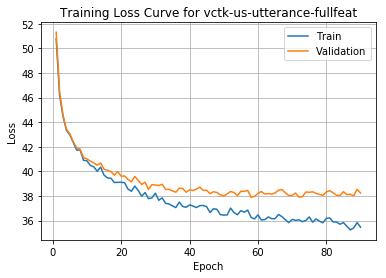

In [251]:
tm_base.plot_loss()

##### Next 90 epochs at noise=2

```python
python train.py --expName='vctk-us-utterance-fullfeat-noise-2' --data='/home/ubuntu/loop/data/vctk' --noise=2 --seq-len=300 --epochs=90 --nspk=22 --checkpoint='checkpoints/vctk-us-utterance-fullfeat/bestmodel.pth'
```

In [6]:
tm_base = tm.TrainingMonitor('vctk-us-utterance-fullfeat-noise-2.csv', exp_name='vctk-us-utterance-fullfeat-noise-2', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [7]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,90,01-Aug-2018 22:29:11,30.990150,32.178386,NaN
1,91,01-Aug-2018 22:35:43,30.499013,31.813037,NaN
2,92,01-Aug-2018 22:42:11,30.294594,31.690778,NaN
3,93,01-Aug-2018 22:48:42,30.403249,31.706255,NaN
4,94,01-Aug-2018 22:55:07,30.048131,31.541041,NaN
5,95,01-Aug-2018 23:01:25,30.453540,31.595458,NaN
6,96,01-Aug-2018 23:07:44,30.228678,31.479022,NaN
7,97,01-Aug-2018 23:14:03,30.051017,31.389431,NaN
8,98,01-Aug-2018 23:20:30,29.911505,31.340574,NaN
9,99,01-Aug-2018 23:26:58,30.022018,31.402550,NaN


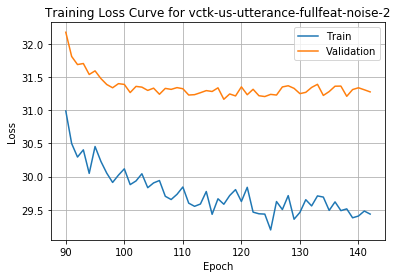

In [8]:
tm_base.plot_loss()

##### Additional epochs with longer seq_len
* first 400
* then 500

In [14]:
tm_base = tm.TrainingMonitor('vctk-us-utterance-fullfeat-noise-2-400.csv', exp_name='vctk-us-utterance-fullfeat-noise-2-400', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [15]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,142,02-Aug-2018 07:47:05,29.361172,31.169793,NaN
1,143,02-Aug-2018 07:53:27,29.552718,31.177302,NaN
2,144,02-Aug-2018 07:59:59,29.368971,31.240569,NaN
3,145,02-Aug-2018 08:06:21,29.298708,31.263335,NaN
4,146,02-Aug-2018 08:12:47,29.326589,31.223143,NaN
5,147,02-Aug-2018 08:19:13,29.591406,31.335768,NaN
6,148,02-Aug-2018 08:25:25,29.481375,31.280081,NaN
7,149,02-Aug-2018 08:31:40,29.316827,31.153419,NaN
8,150,02-Aug-2018 08:37:52,29.400868,31.233101,NaN
9,151,02-Aug-2018 08:44:09,29.565579,31.253004,NaN


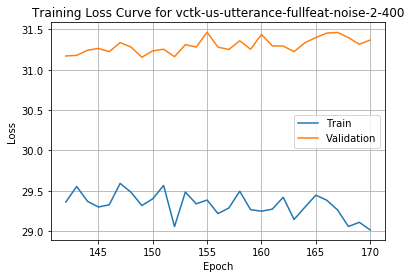

In [16]:
tm_base.plot_loss()

In [18]:
tm_base = tm.TrainingMonitor('vctk-us-utterance-fullfeat-noise-2-500.csv', exp_name='vctk-us-utterance-fullfeat-noise-2-500', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [19]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,170,02-Aug-2018 10:53:37,29.211976,31.140967,NaN
1,171,02-Aug-2018 10:59:47,29.439357,31.165028,NaN
2,172,02-Aug-2018 11:06:07,29.289011,31.215341,NaN
3,173,02-Aug-2018 11:12:22,29.102115,31.285719,NaN
4,174,02-Aug-2018 11:18:35,29.216595,31.184924,NaN
5,175,02-Aug-2018 11:24:42,29.147441,31.235977,NaN
6,176,02-Aug-2018 11:30:48,29.128873,31.216684,NaN
7,177,02-Aug-2018 11:37:00,29.225145,31.053457,NaN
8,178,02-Aug-2018 11:42:59,29.194798,31.185758,NaN
9,179,02-Aug-2018 11:49:03,29.335929,31.203442,NaN


Best final loss...
* 31.167 at seq_len=300
* 31.15 at seq_len=400
* 31.05 at seq_len=500

In [20]:
tm_base.data.valid_loss.min()

31.053456566599998

### VCTK-all
* Now try applying to the full VCTK dataset (for a few epochs at least)
* Ran overnight Thu 02-Aug
* Appears to be training okay

```python
python train.py --expName='vctk-utterance' --data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all' --noise=4 --seq-len=100 --epochs=90 --nspk=107
```

In [24]:
tm_base = tm.TrainingMonitor('vctk-utterance.csv', exp_name='vctk-utterance', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [25]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,1,02-Aug-2018 23:30:07,46.291961,46.260682,NaN
1,2,03-Aug-2018 00:16:54,44.651797,44.664964,NaN
2,3,03-Aug-2018 01:03:26,43.756046,43.792307,NaN
3,4,03-Aug-2018 01:49:36,43.386734,43.336412,NaN
4,5,03-Aug-2018 02:36:26,42.891318,42.874114,NaN
5,6,03-Aug-2018 03:23:01,42.497070,42.457554,NaN
6,7,03-Aug-2018 04:09:55,42.164964,42.249778,NaN
7,8,03-Aug-2018 04:56:07,42.104478,42.132225,NaN
8,9,03-Aug-2018 05:42:06,41.786142,41.798179,NaN
9,10,03-Aug-2018 06:28:38,41.645204,41.768205,NaN


### Training from previous checkpoint
* Trying to load from previous model checkpoint, copy in any old set of utterance encoder network weights, and train from there... worth a try
* Version on VCTK-US appears to be doing okay... unclear how it compares to training it properly, but worth trying out on vctk-all over the weekend

```python
python train.py --expName='vctk-us-test' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --checkpoint='/home/ubuntu/msc-project-master/msc-project-master/checkpoints/vctk-us-train-mon-noise-2/bestmodel.pth' --checkpoint_utterance_embeddings='/home/ubuntu/msc-project-utterance-embeddings/checkpoints/vctk-us-utterance-fullfeat-noise-2-500/bestmodel.pth'
```

In [28]:
tm_base = tm.TrainingMonitor('vctk-us-test.csv', exp_name='vctk-us-test', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [29]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
0,1,31-Jul-2018 18:28:59,51.322497,51.115533,NaN
1,2,31-Jul-2018 18:35:01,46.908355,47.122545,NaN
2,3,31-Jul-2018 18:40:58,44.957545,45.113914,NaN
3,91,03-Aug-2018 14:57:07,37.787291,39.063251,NaN
4,92,03-Aug-2018 15:05:43,37.131446,38.693334,NaN
5,93,03-Aug-2018 15:14:24,36.932819,38.500939,NaN


#### Same for VCTK-all: run from bestmodel of basecase, using epoch12 utterance embeddings as a starting point

```python
python train.py
--expName='vctk-utterance-test-hack-from-chk'
--data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all'
--noise=2
--seq-len=300
--epochs=90
--nspk=107
--checkpoint='/home/ubuntu/msc-project-master/msc-project-master/checkpoints/vctk-all-2-v2/bestmodel.pth'
--checkpoint-utterance-embeddings='/home/ubuntu/msc-project-utterance-embeddings/checkpoints/vctk-utterance/epoch_12.pth'
```

python train.py --expName='vctk-utterance-test-hack-from-chk' --data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all' --noise=2 --seq-len=300 --epochs=90 --nspk=107 --checkpoint='/home/ubuntu/msc-project-master/msc-project-master/checkpoints/vctk-all-2-v2/bestmodel.pth' --checkpoint-utterance-embeddings='/home/ubuntu/msc-project-utterance-embeddings/checkpoints/vctk-utterance/epoch_12.pth'

In [10]:
tm_base = tm.TrainingMonitor('vctk-utterance-test-hack-from-chk.csv', exp_name='vctk-utterance-test-hack-from-chk', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [11]:
#tm_base.disp()

In [12]:
tm_base.data.drop(tm_base.data.index[[0,1]], inplace=True)

In [13]:
tm_base.disp()

,epoch,update_time,train_loss,valid_loss,mcd
2,163,03-Aug-2018 19:40:27,33.407066,33.627501,NaN
3,164,03-Aug-2018 20:17:50,33.278840,33.432096,NaN
4,165,03-Aug-2018 20:54:46,33.096280,33.362820,NaN
5,166,03-Aug-2018 21:31:37,32.939024,33.213029,NaN
6,167,03-Aug-2018 22:08:26,32.873815,33.172811,NaN
7,168,03-Aug-2018 22:45:44,32.832387,33.130184,NaN
8,169,03-Aug-2018 23:23:30,32.776570,33.115379,NaN
9,170,04-Aug-2018 00:00:25,32.728144,33.052429,NaN
10,171,04-Aug-2018 00:37:26,32.708201,33.054986,NaN
11,172,04-Aug-2018 01:14:35,32.695949,33.056672,NaN


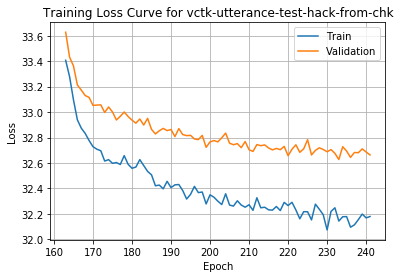

In [16]:
tm_base.plot_loss()

** Mon 06-Aug **
* Sim died overnight because the aws-spot instance restarted (and got a new IP address)
* Sim had been training quite well at noise=2, seq-len=300
* May be worth training it a bit longer though? Some evidence it was still going down a bit
* TODO now...
    * Check out embeddings and samples from latest sim
        * _okay... embeddings look sensible-ish. samples are okay. don't sound as good as basecase but do have some variation by utterance_
    * Run eval_curves esp. to see the speaker classification accuracy
        * _94.7% accuracy on bestmodel. 91.5% after first epoch of re-training. 94.0 after epoch 170. So would hope to get reasonable plot when I rebuild the stats across all the epochs_

In [15]:
tst = ec.calc_eval_curves(checkpoint_folder='checkpoints/vctk-utterance-test-hack-from-chk',
                  checkpoint_file='epoch_170.pth',
                     data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                     speaker_recognition_checkpoint='/home/ubuntu/msc-project-master/msc-project-master/checkpoints/speaker_recognition_vctk_all/bestmodel.pth',
                     speaker_recognition_exp_name='notebook_test',
                     exp_name='vctk_utterance_test_hack_from_chk_eval_curves',
                     max_seq_len=1000,
                     nspk=107,
                     gpu=0,
                     batch_size=64,
                     seed=1,
                     eval_epochs=20,
                     b_teacher_force=True,
                     b_use_train_noise=True
                     )

Valid (loss 32.21) epoch 1: 100%|██████████| 68/68 [01:16<00:00,  1.13s/it]


,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,1,06-Aug-2018 11:00:06,32.7474,33.0545,None,0.939962


In [9]:
tst.disp()

,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,1,06-Aug-2018 10:51:52,32.1195,32.6447,None,0.947166


### Restart the VCTK-all utterance embedding from scratch sim
* The other night I ran it to epoch 12. Now picking it up from that point.

```python
python train.py --expName='vctk-utterance' --data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all' --noise=4 --seq-len=100
--epochs=90 --nspk=107 --checkpoint='/home/ubuntu/msc-project-utterance-embeddings/checkpoints/vctk-utterance/epoch_12.pth'
```

### Quick look at maxpool...
* Fri 03-Aug

```python
python train.py
--expName='vctk-us-utterance-test-maxpool'
--data='/home/ubuntu/loop/data/vctk'
--noise=2
--seq-len=500
--epochs=90
--nspk=22
--checkpoint='/home/ubuntu/msc-project-utterance-embeddings/checkpoints/vctk-us-utterance-fullfeat-noise-2-500/bestmodel.pth'
```

In [21]:
tm_base = tm.TrainingMonitor('vctk-us-utterance-test-maxpool.csv', exp_name='vctk-us-utterance-test-maxpool', path="/home/ubuntu/msc-project-utterance-embeddings/training_logs")

In [22]:
tm_base.disp()
# training well after only a few epochs. Could be worth continuing for more!

,epoch,update_time,train_loss,valid_loss,mcd
0,187,03-Aug-2018 17:00:20,30.082659,31.681927,NaN
1,188,03-Aug-2018 17:06:48,29.710716,31.518697,NaN
2,189,03-Aug-2018 17:13:26,29.530178,31.352733,NaN


In [99]:
tst = ec.calc_eval_curves(checkpoint_folder='checkpoints/vctk-us-utterance',
                  checkpoint_file='bestmodel.pth',
                     data='/home/ubuntu/loop/data/vctk',
                     speaker_recognition_checkpoint='/home/ubuntu/msc-project-master/msc-project-master/checkpoints/speaker-recognition-vctk-us/bestmodel.pth',
                     speaker_recognition_exp_name='notebook_test',
                     exp_name='vckt_us_maxpool_txt',
                     max_seq_len=1000,
                     nspk=22,
                     gpu=0,
                     batch_size=64,
                     seed=1,
                     eval_epochs=20,
                     b_teacher_force=True,
                     b_use_train_noise=True
                     )

RuntimeError: While copying the parameter named embedding_encoder.fc_out.weight_v, whose dimensions in the model are torch.Size([256, 512]) and whose dimensions in the checkpoint are torch.Size([256, 128]).

## Look at the utterance embeddings...
* Will need to open up a data set, run through the embeddings, and then plot them etc.
* Could do with putting as much of this as possible into a module

In [16]:
# VCTK-US-22
checkpoint = 'checkpoints/vctk-us-utterance-fullfeat-noise-2-500/bestmodel.pth'
#checkpoint = 'checkpoints/vctk-us-utterance-test-maxpool/bestmodel.pth'
data_path='/home/ubuntu/loop/data/vctk'
dir = '/numpy_features'
norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'

# VCTK-all
checkpoint = 'checkpoints/vctk-utterance/epoch_12.pth'
data_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all'
dir = '/numpy_features'
norm_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'

# VCTK-all
checkpoint = 'checkpoints/vctk-utterance-test-hack-from-chk/bestmodel.pth'
data_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all'
dir = '/numpy_features'
norm_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'

In [17]:
start_epoch = 1

checkpoint_args_path = os.path.dirname(checkpoint) + '/args.pth'
checkpoint_args = torch.load(checkpoint_args_path)

In [18]:
start_epoch = checkpoint_args[3]
model = Loop(checkpoint_args[0])
model.cuda()

In [19]:
p = torch.load(checkpoint, map_location=lambda storage, loc: storage)
#p.pop('embedding_encoder.h_0', None);
model.load_state_dict(p, strict=True)
model.eval();

In [21]:
dataset = NpzFolder(data_path + dir)
speaker_info = nu.get_vctk_speaker_info()

In [22]:
# remove all the common sentences (proxied by sentences below 100)
npzs = dataset.npzs
dataset.npzs = [x for (x, i) in zip(npzs, [int(os.path.split(n)[1][:-4].split('_')[1]) for n in npzs]) if i > 100]

In [23]:
# loader wrapper
loader = NpzLoader(dataset,
                             max_seq_len=1000,
                             batch_size=64,
                             num_workers=4,
                             pin_memory=True,
                             shuffle=False)

In [24]:
# ref data for speaker id and gender
spkr_dict = dict()
spkr_gender = dict()
for (k,i) in dataset.speakers.items():
    spkr_dict[i]= k 
    spkr_gender[i] = np.array(speaker_info[speaker_info.id == int(k[1:])]['gender'])[0]

spkr_lookup = spkr_dict.values()
spkr_gender_lookup = spkr_gender.values()

# ref data for phones
phone_dict = dict([[v,k] for k,v in dataset.dict.items()])
phone_lookup = np.array(phone_dict.values())

In [25]:
# get embeddings for individual utterances
train_enum = tqdm(loader, desc='Loader')
all_embedding_array = []
all_spkr = []
all_txt = []
all_len = []
all_str = []
all_feat = []
all_feat_len = []
c = 0
for full_txt, full_feat, spkr in train_enum:
    print c
    embedding_array = model.get_embeddings(wrap(full_feat[0]), start=True)
    all_embedding_array.append(embedding_array.data.cpu().numpy())
    all_spkr.append(spkr.cpu().numpy().flatten())
    all_txt.append(np.array(full_txt[0]))
    all_len.append(full_txt[1])
    all_feat.append(full_feat[0].cpu().numpy())
    all_feat_len.append(full_feat[1].numpy())
    
    c += 1
    if c == 20:
        break

Loader:   0%|          | 0/466 [00:00<?, ?it/s]

0


Loader:   1%|          | 4/466 [00:01<02:31,  3.05it/s]

1
2
3
4
5
6


Loader:   2%|▏         | 10/466 [00:01<01:11,  6.34it/s]

7
8
9
10


Loader:   3%|▎         | 13/466 [00:01<00:58,  7.72it/s]

11
12


Loader:   3%|▎         | 15/466 [00:01<00:57,  7.88it/s]

13
14
15
16


Loader:   4%|▍         | 18/466 [00:02<00:52,  8.53it/s]

17
18
19


In [26]:
# concatenate the ref data across all the batches
embeddings = np.concatenate(all_embedding_array)
spkr = np.concatenate(all_spkr)
all_len = np.concatenate(all_len)
all_feat_len = np.concatenate(all_feat_len)

In [27]:
# remove all short utterances to keep the analysis cleaner
idx_kill = all_feat_len < 300

embeddings = np.delete(embeddings, np.flatnonzero(idx_kill), axis=0)
spkr = np.delete(spkr, np.flatnonzero(idx_kill))
all_len = np.delete(all_len, np.flatnonzero(idx_kill))
all_feat_len = np.delete(all_feat_len, np.flatnonzero(idx_kill))
#all_feat[0] = np.delete(all_feat[0], np.flatnonzero(idx_kill), axis=1)

In [28]:
# pairwise cosine similarities between the embeddings
cs = pw.cosine_similarity(embeddings)

#### Quick analysis of individual utterances / embeddings

In [29]:
# lookup the phones for each utterance
all_txt_list = []
all_str = []
for i in all_txt:
    for j in range(i.shape[1]):
        all_txt_list.append(i[:,j])
        x = i[:,j]
        x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
        #print " ".join(phone_lookup[x])
        all_str.append(" ".join(phone_lookup[x]))

In [30]:
x = all_txt_list[19]
x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
print " ".join(phone_lookup[x])

ax m ae n hh ae z s ih n s b ih n ch aa r jh d w ih dh hh ih z m er d er pau pau pau pau pau pau pau pau pau pau pau pau pau pau pau pau pau


In [31]:
# play an utterance from the raw features
#feats = np.load('/home/ubuntu/loop/data/vctk/numpy_features/p362_409.npz')
#f = copy.deepcopy(feats['audio_features'])
x = dict()
#x['audio_features'] = f
x['audio_features'] = all_feat[0][:,9,:] #9 10
nu.play_synthesized_features(x, norm_path=norm_path)

complete test.wav.wav.


(16000, array([    4,     0,     0, ...,  -114,  -114, -2576], dtype=int16))

In [436]:
#tmp = model.get_embeddings(wrap(torch.from_numpy(all_feat[0][:,9,:].reshape(-1,1,63))), start=True).data.cpu().numpy()
#tmp = model.get_embeddings(wrap(torch.from_numpy(np.ones([681,1,63])).type(torch.FloatTensor)), start=True).data.cpu().numpy()

In [32]:
np.sqrt(np.sum((embeddings[6,:] - embeddings[9,:])**2))

0.3257288

### Heatmap of pairwise cosine similarities of embeddings

In [33]:
# vctk speaker ids and genders for each utterance
batch_spkr_vctk = [int(spkr_lookup[i][1:])  for i in spkr]
batch_spkr_gender = [spkr_gender_lookup[i]  for i in spkr]

In [34]:
# label for each utterance
label = [str(a) + '_' + b + '_' + str(c) for (a, b, c) in zip(batch_spkr_vctk, batch_spkr_gender, all_len)]

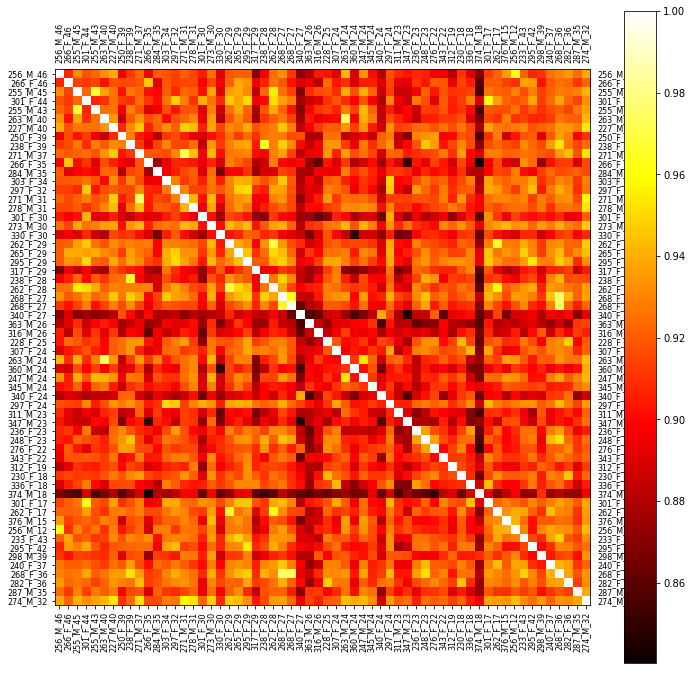

In [35]:
# plot heatmap
max_show = 60
plt.figure(figsize=(12,12))
plt.imshow(cs[:max_show, :max_show], cmap='hot', interpolation='nearest')#, vmin=0.8, vmax=1)
plt.colorbar()
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.xticks(range(max_show))
plt.gca().set_xticklabels(label[:max_show], rotation='vertical')
plt.yticks(range(max_show))
plt.gca().set_yticklabels(label[:max_show])
plt.gca().xaxis.set_tick_params(labeltop='on')
plt.gca().yaxis.set_tick_params(labelright='on')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

#### Look at distributions of same-speaker vs. diff-speaker embeddings

In [36]:
# pick an utterance
idx_spkr_check = 20

e = (spkr == spkr[idx_spkr_check])
idx = np.flatnonzero(e)

In [37]:
dist_in = cs[idx_spkr_check, idx[np.flatnonzero(np.logical_not(np.isin(idx, idx_spkr_check)))]]

Loader:   4%|▍         | 18/466 [00:20<08:18,  1.11s/it]

In [38]:
dist_out = cs[idx_spkr_check, np.flatnonzero(np.logical_not(e))]

In [39]:
dist_in.mean() - dist_in.std()

0.9765712

In [40]:
dist_out.mean() + dist_out.std()

0.93712991

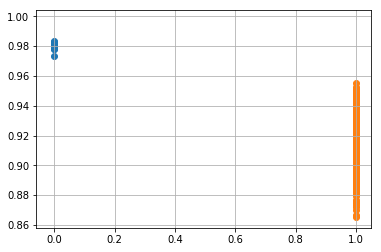

In [41]:
plt.figure()
plt.scatter(np.zeros_like(dist_in), dist_in)
plt.scatter(np.ones_like(dist_out), dist_out)
plt.grid(True)

In [43]:
# Show most similar utterances to a reference utterance
idx_utt = 10

# ones at the top should be for the same speaker!
t = pd.DataFrame()
t['cosine_sim'] = cs[idx_utt, :]
t['spkr_id'] = spkr
t.sort_values('cosine_sim', ascending=False).head(20)

,cosine_sim,spkr_id
10,1.000000,39
553,0.966011,39
954,0.965657,39
732,0.963059,39
1,0.946937,39
742,0.940969,26
1026,0.939562,55
153,0.939266,26
497,0.938444,35
327,0.938258,39


In [44]:
# show similarities of all utterances for this speaker
t[t.spkr_id == spkr[idx_utt]]

,cosine_sim,spkr_id
1,0.946937,39
10,1.000000,39
200,0.932038,39
327,0.938258,39
553,0.966011,39
732,0.963059,39
954,0.965657,39


### t-sne scatter plot

In [45]:
# t-sne
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(embeddings)

In [46]:
idx_m = [b == 'M' for b in batch_spkr_gender]
idx_f = [b == 'F' for b in batch_spkr_gender]

In [47]:
##### t-sne male vs. female

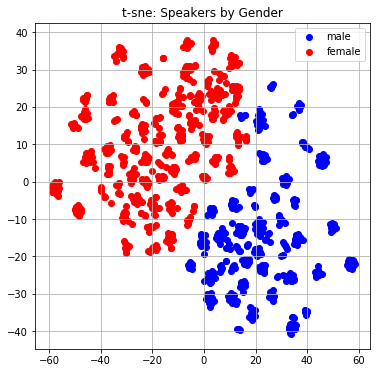

In [48]:
plt.figure(figsize=(6,6))
m_plot = plt.scatter(tsne_fit[idx_m, 0], tsne_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(tsne_fit[idx_f, 0], tsne_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('t-sne: Speakers by Gender')
plt.show()

##### t-sne by speaker id

In [49]:
u_spkr = np.unique(spkr)
num_spkr = len(u_spkr)

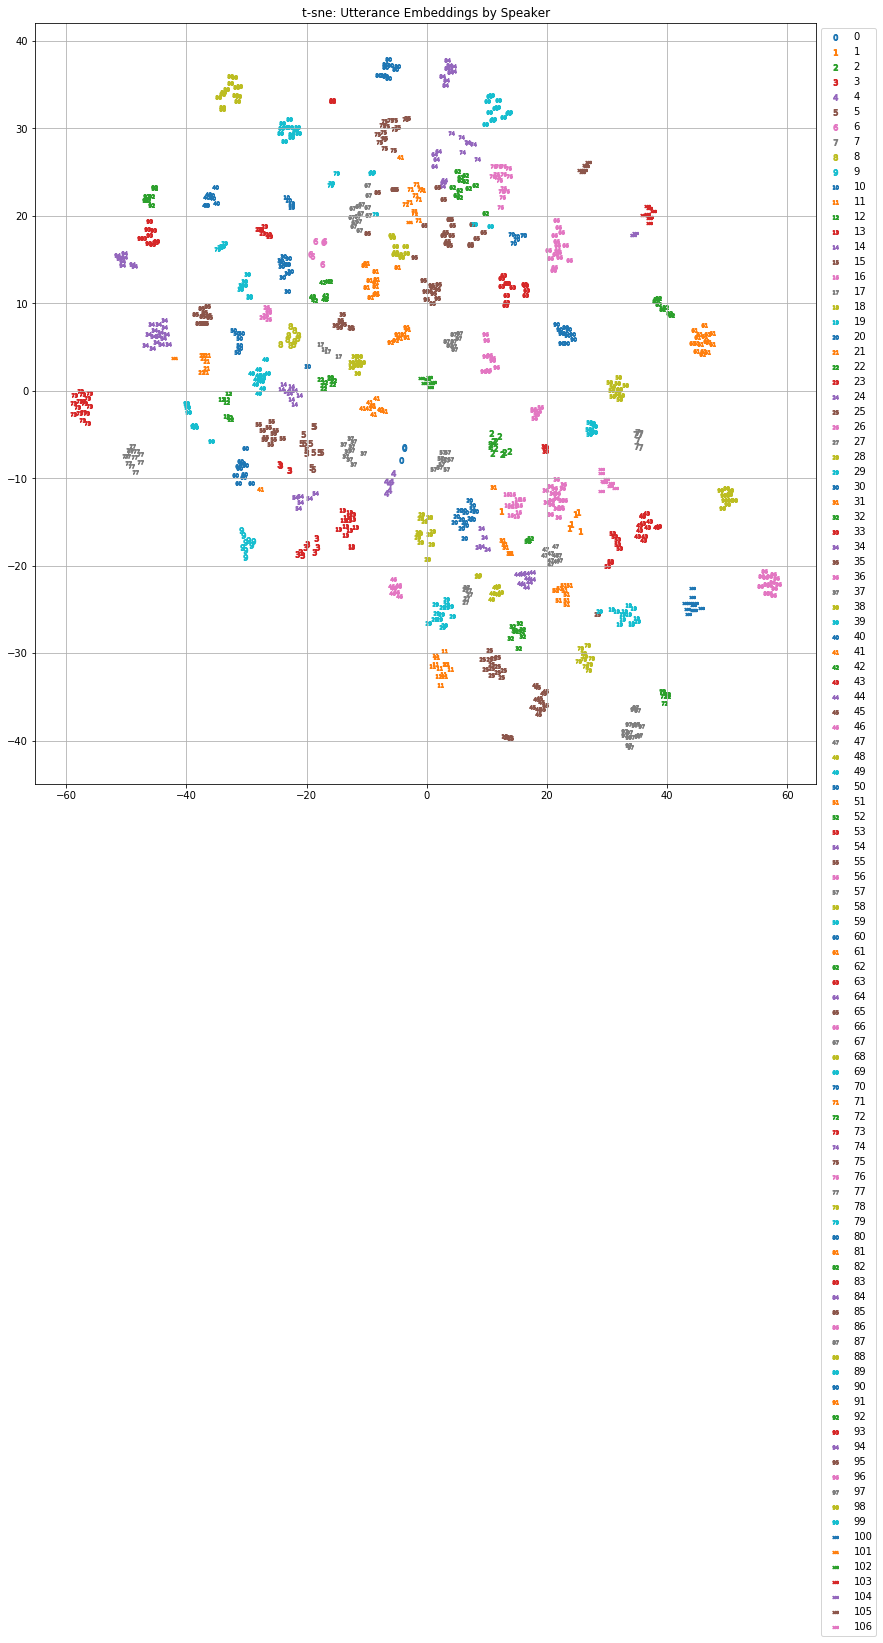

In [50]:
plt.figure(figsize=(14,14))
for s in u_spkr:
    idx_this_spkr = (spkr == s)# & idx_gender_to_show
    #print(str(idx_this_accent.sum()))
    #print str(np.sum(idx_this_accent))

    plt.scatter(tsne_fit[idx_this_spkr, 0], tsne_fit[idx_this_spkr, 1], marker=r'$'+str(s)+'$')
    #f_plot = plt.scatter(S_tsne[idx_other, 0], S_tsne[idx_other, 1], c='r', label='other')

plt.legend(u_spkr, loc='upper left', bbox_to_anchor=(1,1))
plt.grid()
plt.title('t-sne: Utterance Embeddings by Speaker')
plt.show()

In [51]:
# check out extreme points (for diagnosing the blobl)
e = np.flatnonzero(tsne_fit[:,0] < -40)

In [52]:
print cs.mean(axis=1)[tsne_fit[:,0] < -40].mean()
print cs.mean(axis=1)[tsne_fit[:,0] > -40].mean()

0.901439
0.909766


### PCA analyis

In [53]:
# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

##### PCA by gender

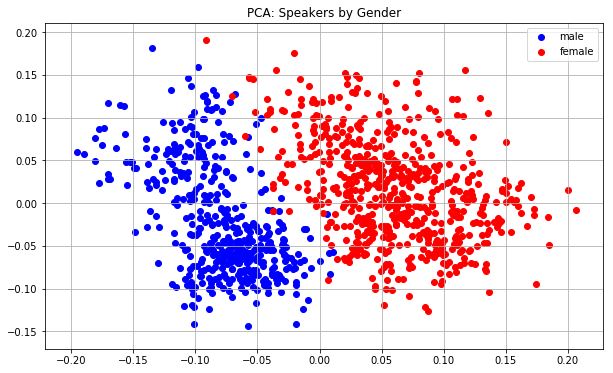

In [54]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')
plt.show()

##### PCA by speaker id

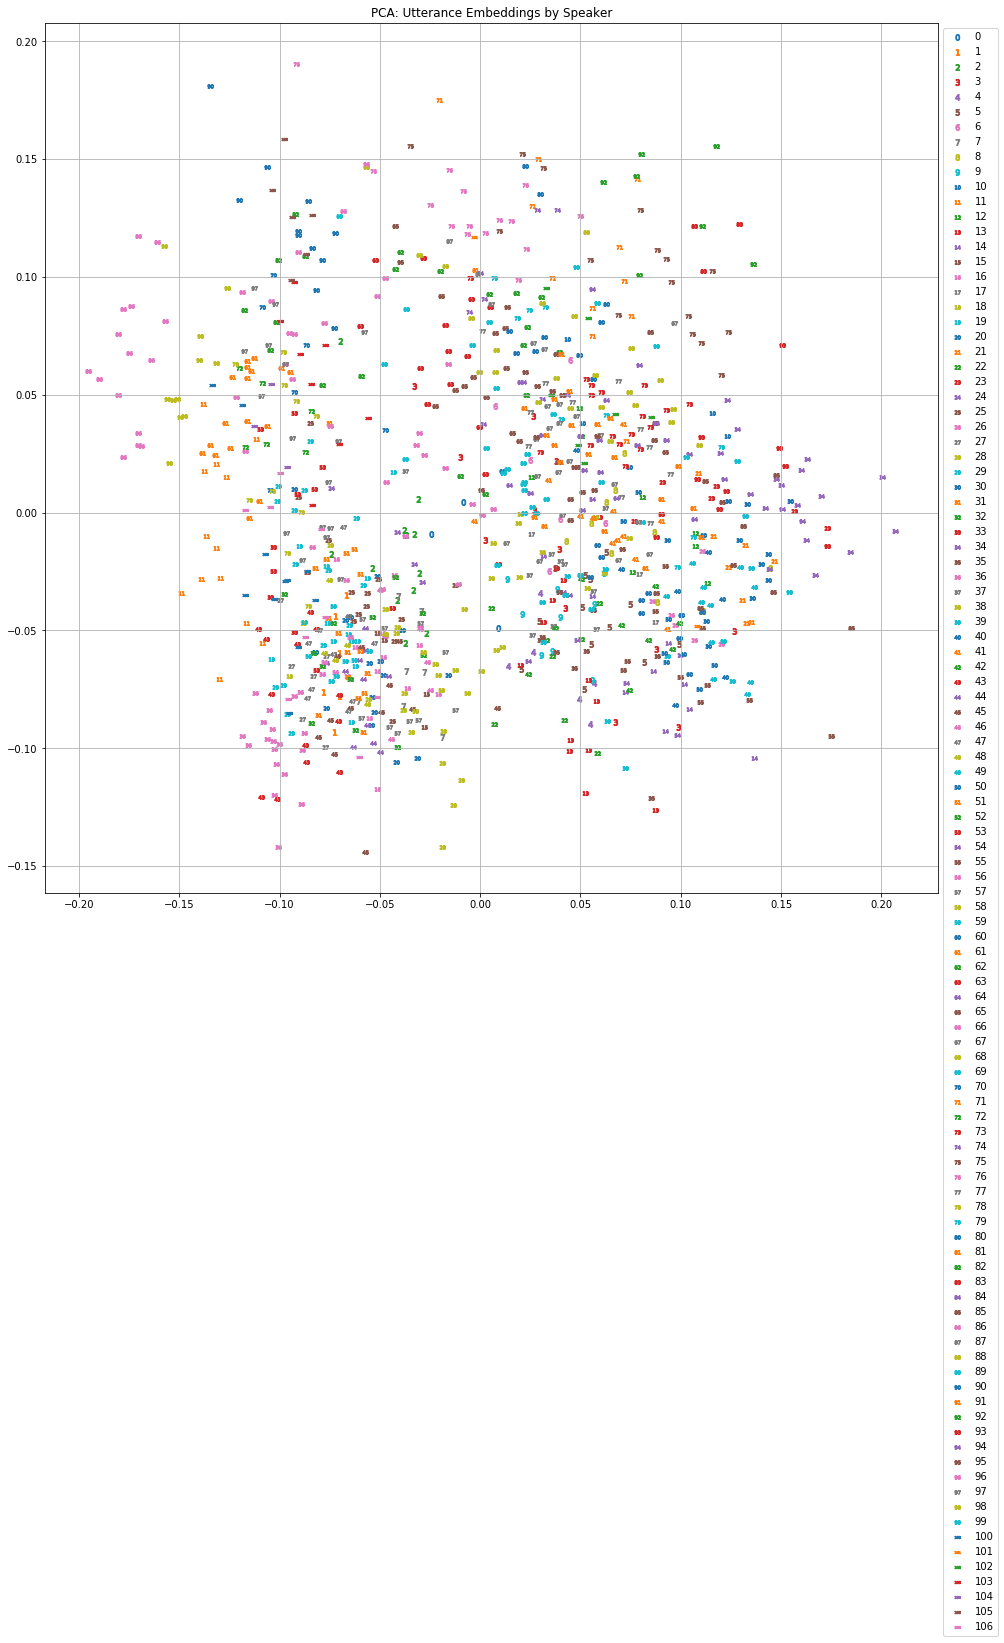

In [55]:
plt.figure(figsize=(16,16))
for s in u_spkr:
    idx_this_spkr = (spkr == s)# & idx_gender_to_show
    #print(str(idx_this_accent.sum()))
    #print str(np.sum(idx_this_accent))

    plt.scatter(pca_fit[idx_this_spkr, 0], pca_fit[idx_this_spkr, 1], marker=r'$'+str(s)+'$')
    #f_plot = plt.scatter(S_tsne[idx_other, 0], S_tsne[idx_other, 1], c='r', label='other')

plt.legend(u_spkr, loc='upper left', bbox_to_anchor=(1,1))
plt.grid()
plt.title('PCA: Utterance Embeddings by Speaker')
plt.show()

## !!! NEXT !!!
* try running from main model checkpoint
* only calculate the embedding once? Or actually maybe it helps to keep recalculating the embedding?? need to test
* quick go of other pooling methods
* dropout: should the values be lower?


## Generate some samples
* Would be a good time to put some of this code into a module...

In [56]:
this_embedding = torch.zeros(1,256,1).cuda()

### VCTK-all after hacking on top of previously-trained model
* Fri 03-Aug

In [57]:
speaker_info

,id,age,gender,accents,region
225,225,23,F,English,Southern England
226,226,22,M,English,Surrey
227,227,38,M,English,Cumbria
228,228,22,F,English,Southern England
229,229,23,F,English,Southern England
230,230,22,F,English,Stockton-on-tees
231,231,23,F,English,Southern England
232,232,23,M,English,Southern England
233,233,23,F,English,Staffordshire
234,234,22,F,Scottish,West Dumfries


In [325]:
# 313_355
#232_155
#this results in an encoding matrix 313, 232_188_334_375, 376, 364, 345, 312
#253_336, 136, 156, 165, 067, 085
out_dict = nu.generate_sample_with_loop(npz='p253_242.npz', text='this results in an encoding matrix', spkr_id=1, gender=1,
                              checkpoint='checkpoints/vctk-utterance-test-hack-from-chk/bestmodel.pth',
                              output_dir='./',
                              npz_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                              output_file_override=None,
                              embedding_array=None)

this results in an encoding matrix
torch.Size([658, 1, 63])
torch.Size([658, 1, 63])
complete this_results_in_an_encoding_matrix.wav.
complete p253_242.orig.wav.


In [123]:
phone_dict

{0: u'pau',
 1: u'iy',
 2: u'aa',
 3: u'ch',
 4: u'ae',
 5: u'eh',
 6: u'ah',
 7: u'ao',
 8: u'ih',
 9: u'ey',
 10: u'aw',
 11: u'ay',
 12: u'ax',
 13: u'er',
 14: u'ng',
 15: u'sh',
 16: u'th',
 17: u'uh',
 18: u'zh',
 19: u'oy',
 20: u'dh',
 21: u'ow',
 22: u'hh',
 23: u'jh',
 24: u'b',
 25: u'd',
 26: u'g',
 27: u'f',
 28: u'k',
 29: u'm',
 30: u'l',
 31: u'n',
 32: u'p',
 33: u's',
 34: u'r',
 35: u't',
 36: u'w',
 37: u'v',
 38: u'y',
 39: u'z',
 40: u'uw'}

In [176]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))

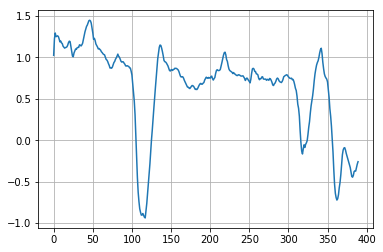

In [326]:
# using 232_156
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

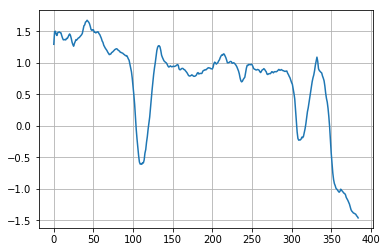

In [301]:
# using 232_085
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

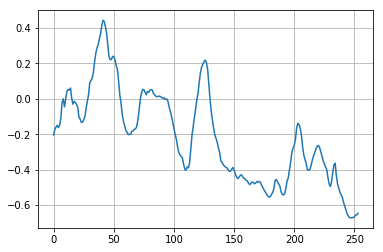

In [252]:
# using 232_371
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

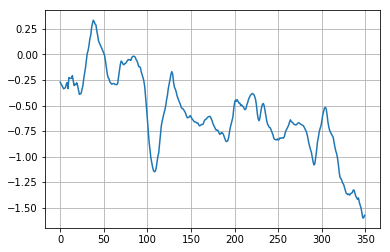

In [243]:
# using 232_334
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

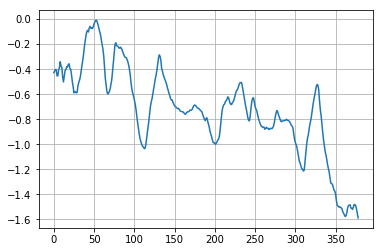

In [246]:
# using 232_188
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

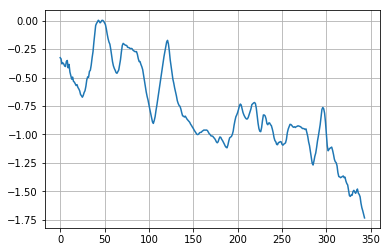

In [248]:
# using 232_375
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

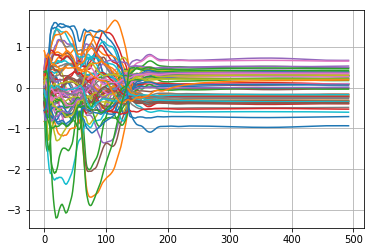

In [89]:
plt.plot(out_dict['loop_feat'].squeeze())
plt.grid()
plt.show()

## Distribution of utterance embeddings for a single speaker
* Mon 06-Aug
* Find all utterances for a given speaker and extract all the embeddings
* Look at how these are distributed in the speaker space
* Any interesting structure?

In [552]:
dataset = NpzFolder(data_path + dir)
speaker_info = nu.get_vctk_speaker_info()

In [553]:
speaker_id = 298 # Irish Male, a bit more prosody than many other speakers

In [554]:
# keep only utterances for the selected speaker_id
npzs = dataset.npzs
npzs = [x for (x, i) in zip(npzs, [os.path.split(n)[1][:-4].split('_')[0] for n in npzs]) if i == 'p'+str(speaker_id)]
dataset.npzs = npzs

In [555]:
len(dataset.npzs)

364

In [556]:
# loader wrapper
loader = NpzLoader(dataset,
                             max_seq_len=5000, # hack for now
                             batch_size=64,
                             num_workers=4,
                             pin_memory=True,
                             shuffle=False)

In [557]:
# load in text string
sample_dict = dict()
speaker_dict = dict()
utterances = []
for d in npzs:
    _, fname = os.path.split(d)
    spkr_vctk, idx_sentence = fname[:-4].split('_')

    vctk_corpus_root = '/home/ubuntu/VCTK-Corpus/'
    txt_file = '/home/ubuntu/VCTK-Corpus/txt/p362/p362_409.txt'
    txt_file = os.path.join(vctk_corpus_root, 'txt', spkr_vctk, fname[:-4] + '.txt')
    f = open(txt_file, 'r')
    transcript = f.read()
    f.close()

    sample_dict['npz_file'] = d
    sample_dict['transcript'] = transcript
    sample_dict['idx_sentence'] = int(idx_sentence)

    speaker_dict[idx_sentence] = copy.deepcopy(sample_dict)
    utterances.append(copy.deepcopy(sample_dict))

In [558]:
sent = [u['transcript'] for u in utterances]

In [559]:
sent_is_question = [s.find('?') > -1 for s in sent]

In [560]:
sent_is_not_question = [s==False for s in sent_is_question]

In [561]:
print sum(sent_is_question)
print sum(sent_is_not_question)

21
343


In [562]:
# do some basic analysis on the utterances (question marks, length...)
# number of commas
# exclamation marks?
# length (number of phones?)
# 

In [563]:
# get embeddings for individual utterances
train_enum = tqdm(loader, desc='Loader', )
all_embedding_array = []
all_spkr = []
all_txt = []
all_len = []
all_str = []
all_feat = []
all_feat_len = []
c = 0
for full_txt, full_feat, spkr in train_enum:
    print c
    embedding_array = model.get_embeddings(wrap(full_feat[0]), start=True)
    all_embedding_array.append(embedding_array.data.cpu().numpy())
    all_spkr.append(spkr.cpu().numpy().flatten())
    all_txt.append(np.array(full_txt[0]))
    all_len.append(full_txt[1])    
    all_feat_len.append(full_feat[1].numpy())
    ff = full_feat[0].cpu().numpy()
    for i in range(ff.shape[1]):
        all_feat.append(ff[:, i, :])
    
    #c += 1
    #if c == 20:
    #    break


Loader:  50%|█████     | 3/6 [00:00<00:00,  4.12it/s]

0
0
0



Loader: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]

0
0
0


In [564]:
# concatenate the ref data across all the batches
embeddings = np.concatenate(all_embedding_array)
spkr = np.concatenate(all_spkr)
all_len = np.concatenate(all_len)
all_feat_len = np.concatenate(all_feat_len)

In [565]:
# remove all short utterances to keep the analysis cleaner
idx_kill = all_feat_len < 300

embeddings = np.delete(embeddings, np.flatnonzero(idx_kill), axis=0)
spkr = np.delete(spkr, np.flatnonzero(idx_kill))
all_len = np.delete(all_len, np.flatnonzero(idx_kill))
all_feat_len = np.delete(all_feat_len, np.flatnonzero(idx_kill))
#all_feat[0] = np.delete(all_feat[0], np.flatnonzero(idx_kill), axis=1)
all_feat = [q for (q, i) in zip(all_feat, idx_kill) if not i]

sent_is_question = [q for (q, i) in zip(sent_is_question, idx_kill) if not i]
sent_is_not_question = [q for (q, i) in zip(sent_is_not_question, idx_kill) if not i]

In [566]:
len(all_feat_len) # 345 out of original 364: we lose 19 because they're longer than 1000 steps long

361

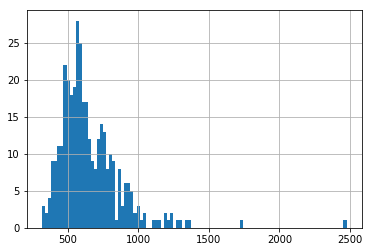

653.900277008


In [567]:
plt.hist(all_feat_len, 100); plt.grid(); plt.show()
print(all_feat_len.mean())

In [568]:
# pairwise cosine similarities between the embeddings
cs = pw.cosine_similarity(embeddings)

In [569]:
print cs.mean()
print np.percentile(cs, 1)
print cs.min()

if False:
    # plot heatmap
    max_show = 300
    plt.figure(figsize=(12,12))
    plt.imshow(cs[:max_show, :max_show], cmap='hot', interpolation='nearest')#, vmin=0.8, vmax=1)
    plt.colorbar()
    #plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.xticks(range(max_show))
    #plt.gca().set_xticklabels(label[:max_show], rotation='vertical')
    plt.yticks(range(max_show))
    #plt.gca().set_yticklabels(label[:max_show])
    plt.gca().xaxis.set_tick_params(labeltop='on')
    plt.gca().yaxis.set_tick_params(labelright='on')
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.show()

0.955598
0.913384473324
0.848204


In [570]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

In [571]:
pca.explained_variance_

array([ 0.00856641,  0.00643093], dtype=float32)

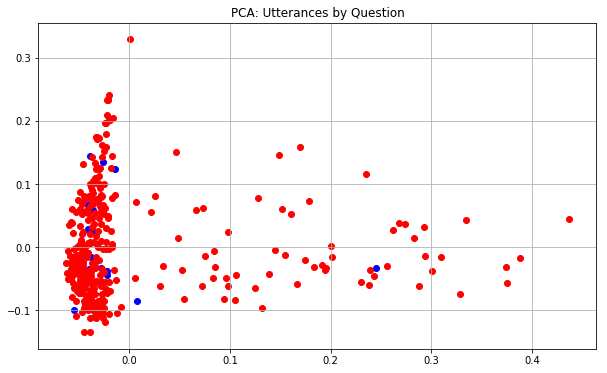

In [572]:
plt.figure(figsize=(10,6))
q_plot = plt.scatter(pca_fit[sent_is_question, 0], pca_fit[sent_is_question, 1], c='b', label='question')
nonq_plot = plt.scatter(pca_fit[sent_is_not_question, 0], pca_fit[sent_is_not_question, 1], c='r', label='non question')
#leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Utterances by Question')
plt.show()

If we include all the short utterances then the plot smears out a lot... but if we cut off at 550 and below, then there's no clear separation by utterance length any more

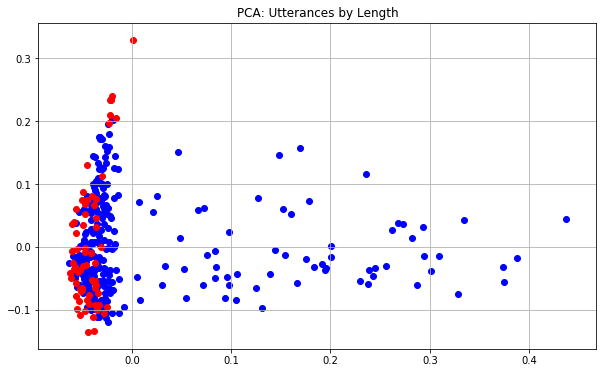

In [573]:
cutoff_len = 800
plt.figure(figsize=(10,6))
q_plot = plt.scatter(pca_fit[all_feat_len<cutoff_len, 0], pca_fit[all_feat_len<cutoff_len, 1], c='b', label='short')
nonq_plot = plt.scatter(pca_fit[all_feat_len>=cutoff_len, 0], pca_fit[all_feat_len>=cutoff_len, 1], c='r', label='long')
#leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Utterances by Length')
plt.show()

In [541]:
mean_lf0 = np.array([all_feat[idx][:all_feat_len[idx], 61].mean() for idx in range(len(all_feat))])
#mean_lf0 = np.array([get_trimmed_lf0(all_feat[idx], all_feat_len[idx]).mean() for idx in range(len(all_feat))])

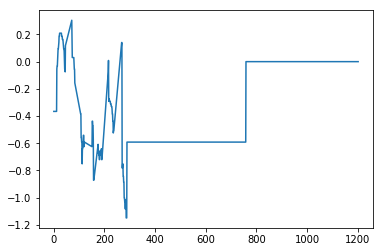

In [542]:
plt.plot(all_feat[100][:, 61])

In [524]:
p = all_feat[100][:all_feat_len[100], 61]

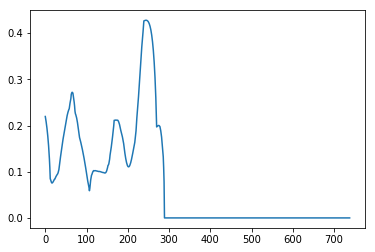

In [525]:
plt.plot([np.std(p[i:i+50]) for i in range(0, len(p)-20)])

In [543]:
def get_trimmed_lf0(feats, seq_len, tst_length=50):
    #feats = feats.squeeze()
    p = feats[:seq_len, 61]
    flatline_chk = [np.std(p[i:i+tst_length]) for i in range(0, len(p)-tst_length)]
    idx_flatline = np.abs(flatline_chk) < 1e-8
    
    if np.any(idx_flatline):
        idx_kill_start = np.flatnonzero(idx_flatline).min()
        p = p[:idx_kill_start]
        
    return p

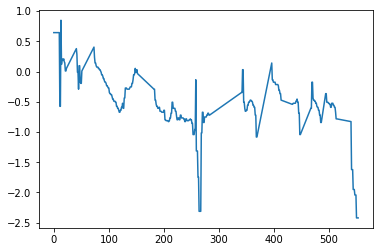

In [544]:
plt.plot(get_trimmed_lf0(all_feat[10], all_feat_len[10]))


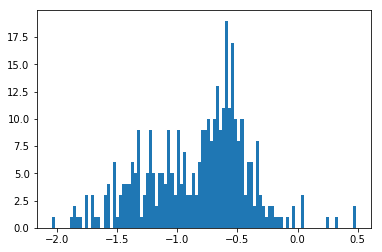

In [545]:
plt.hist(mean_lf0, 100);

In [550]:
np.percentile(mean_lf0, [33, 50, 67])

array([-1.00683596, -0.73668474, -0.59050084])

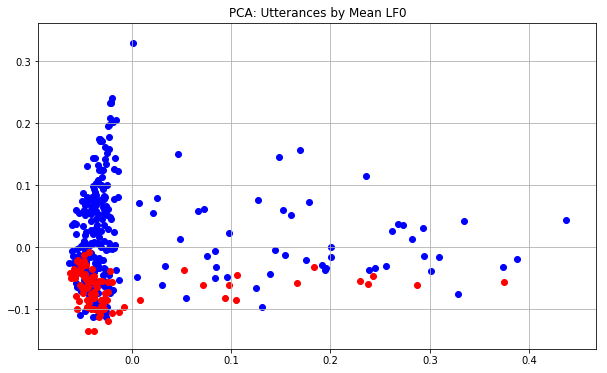

In [547]:
cutoff = -0.54
plt.figure(figsize=(10,6))
low_plot = plt.scatter(pca_fit[mean_lf0<cutoff, 0], pca_fit[mean_lf0<cutoff, 1], c='b', label='low')
high_plot = plt.scatter(pca_fit[mean_lf0>=cutoff, 0], pca_fit[mean_lf0>=cutoff, 1], c='r', label='high')
#leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Utterances by Mean LF0')
plt.show()

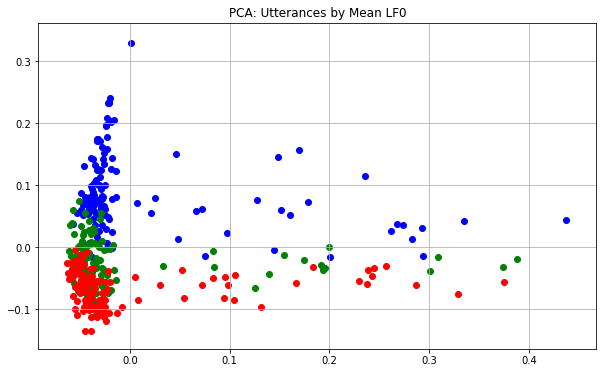

In [551]:
cutoff_low = -1
cutoff_high = -0.6
plt.figure(figsize=(10,6))
low_plot = plt.scatter(pca_fit[mean_lf0<cutoff_low, 0], pca_fit[mean_lf0<cutoff_low, 1], c='b', label='low')
idx_med = np.logical_and(mean_lf0<cutoff_high, mean_lf0>=cutoff_low)
med_plot = plt.scatter(pca_fit[idx_med, 0], pca_fit[idx_med, 1], c='g', label='med')
high_plot = plt.scatter(pca_fit[mean_lf0>=cutoff_high, 0], pca_fit[mean_lf0>=cutoff_high, 1], c='r', label='high')
#leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Utterances by Mean LF0')
plt.show()

In [411]:
# can we do rising pitch? falling pitch?

0.3268698060941828

#### Look at samples generated with the extremes of the input utterances

In [349]:
pca_fit[193, :]

array([-0.05253127, -0.10863962], dtype=float32)

In [462]:
# next: pull out some of the examples from the extremes. Listen to then
idx = np.flatnonzero(pca_fit[:, 1] < -0.11)
idx = np.flatnonzero(pca_fit[:, 1] > 0.2)

In [463]:
idx

array([ 38, 102, 174, 229, 243, 252, 253, 304, 355])

In [465]:
[utterances[i] for i in idx]

[{'idx_sentence': 129,
  'npz_file': '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features/p298_129.npz',
  'transcript': 'We have great team spirit.'},
 {'idx_sentence': 158,
  'npz_file': '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features/p298_158.npz',
  'transcript': 'She was shouting my baby, my baby.'},
 {'idx_sentence': 249,
  'npz_file': '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features/p298_249.npz',
  'transcript': 'We can just get on with our game.'},
 {'idx_sentence': 183,
  'npz_file': '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features/p298_183.npz',
  'transcript': 'Two men have been charged with his murder.'},
 {'idx_sentence': 72,
  'npz_file': '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features/p298_072.npz',
  'transcript': 'What do they pay to join the club?'},
 {'idx_sentence': 203,
  'npz_file': '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_feature

In [470]:
mean_lf0[idx]

array([-1.57644403, -1.85039902, -2.04258776, -1.86185551, -1.83046556,
       -1.7462672 , -1.67450476, -1.81373215, -1.86669755], dtype=float32)

In [479]:
# play some samples...
idx_to_play = idx[6]
npz = 'p' + str(speaker_id) + '_' + str(utterances[idx_to_play]['idx_sentence']) + '.npz'
npz = 'p298_292.npz'
out_dict = nu.generate_sample_with_loop(npz=npz, text='we have great team spirit', spkr_id=1, gender=1,
                              checkpoint='checkpoints/vctk-utterance-test-hack-from-chk/bestmodel.pth',
                              output_dir='./',
                              npz_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features',
                              output_file_override='test',
                              embedding_array=None)

we have great team spirit
torch.Size([518, 1, 63])
torch.Size([518, 1, 63])
complete test.wav.
complete p298_292.orig.wav.


In [480]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))
print out_dict['feat'][:, 0, 61].mean()

-0.0859091


In [ ]:
# using p298_292 "I have been coming here for nine years"
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

print out_dict['loop_feat'][:, 0, 61].mean()

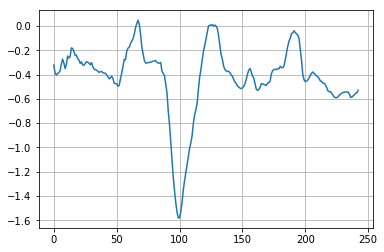

-0.424416


In [481]:
# using p298_292 "I have been coming here for nine years"
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

print out_dict['loop_feat'][:, 0, 61].mean()

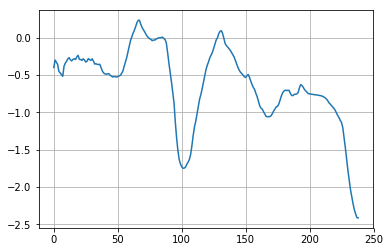

-0.625499


In [469]:
# using p298_129 "we have great team spirit
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

plt.plot(out_dict['loop_feat'][:, 0, 61])
plt.grid(True)
plt.show()

print out_dict['loop_feat'][:, 0, 61].mean()

### "It raises the edge" Analysis
* Thu 02-Aug am
* Generate this sentence for speaker 329 using a range of that speaker's utterance embeddings
* The generated samples do sound slightly different, in terms of quality, enunciation, stress, inflection...
* But can we tie the differences back to differences in the source utterances? In their linguistic content (question? long/short?) or the speech style?

In [108]:
#p329_315.npz
#215
#415
# 403: It's going to be great!
out_dict = nu.generate_sample_with_loop(npz='p362_038.npz', text='It raises the edge', spkr_id=10, gender=1,
                              checkpoint='checkpoints/vctk-us-utterance-fullfeat-noise-2-500/bestmodel.pth',
                              output_dir='./',
                              npz_path='/home/ubuntu/loop/data/vctk/numpy_features',
                              output_file_override=None,
                              embedding_array=None)

It raises the edge
torch.Size([240, 1, 63])
torch.Size([240, 1, 63])
complete It_raises_the_edge.wav.
complete p362_038.orig.wav.


In [106]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))

In [107]:
# using 329_038: Was this a new event?
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [352]:
# using 329_068: How is he enjoying life as a senior?
# faster speaking rate, stops early on the 'edge'
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [348]:
# using 329_008: Long test sentence
# clearer 't', generally better enunciated?
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [343]:
# using 329_141: As agreed, the prime minister was driven to Westminster Hall.
# 
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [340]:
# using 329_141: That is my dream
# 
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [336]:
# using 329_160: Even for a British Open, this is different
# clear enunciation on the 't'
# longer time spent on 'edge' - is this because the ref utterance was longer?
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [332]:
# using 329_171: Do you wanna see it? (not spoken exactly as per transcript)
# 
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [329]:
# using 329_179: What was that all about?
# 'raises' is much more clearly enunciated
# stronger stress on 'raises'; 'edge' mumbled a bit
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [325]:
# using 329_200: Who are the public
# low quality, not very intelligible
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [309]:
# using 329_403: It's going to be great
# intonation increases towards the end of the sentence
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [317]:
#415: It raises the edge
# i.e. used to recreate the original sentence
# quite flat, weakly stresses 'raises' and 'edge'
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [321]:
# 215: We are not a retailer, we provide a service
# more stress on 'raises'; 'edge' is mumbled away a bit
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

### Thu am: Repeat for a different speaker

In [462]:
#p329_315.npz
#215
#415
# 403: It's going to be great!
out_dict = nu.generate_sample_with_loop(npz='p311_114.npz', text='', spkr_id=10, gender=1,
                              checkpoint='checkpoints/vctk-us-utterance-fullfeat-noise-2-400/bestmodel.pth',
                              output_dir='./',
                              npz_path='/home/ubuntu/loop/data/vctk/numpy_features',
                              output_file_override=None,
                              embedding_array=None)

torch.Size([177, 1, 63])
torch.Size([177, 1, 63])
complete p311_114_10.wav.
complete p311_114.orig.wav.


In [463]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))

In [464]:
# using 329_074: How do we get more people in?
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [415]:
# using 329_069: It will include the Black Watch, the Royal Highland Regiment
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [408]:
# using 329_260: What is so unusual about this case?
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [401]:
# using 329_368: Anything that was going, really
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [398]:
# using 329_328: I am not against a further inquiry
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [395]:
# using 329_128: She has left the island
#
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [412]:
# using 329_382: Or is it?
# cuts short. Is this a problem with the meanpooling in the conv net?
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

### Wed Night: Early examples

#### p362_415 It raises the edge

In [244]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))

In [245]:
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

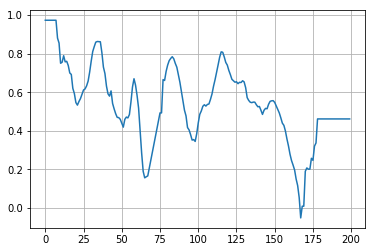

In [248]:
plt.plot(out_dict['feat'][:,0,61])
plt.grid(True)

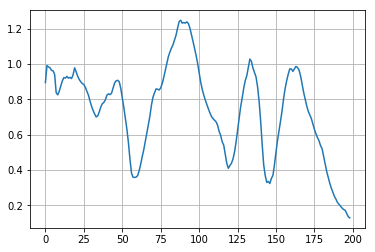

In [247]:
plt.plot(out_dict['loop_feat'][:,0,61])
plt.grid(True)

#### p362_415 We are not a retailer, we provide a service

In [233]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))

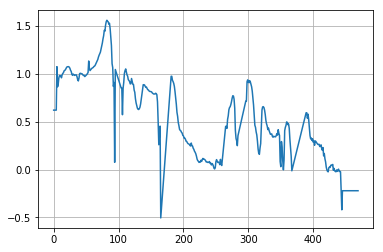

In [237]:
plt.plot(out_dict['feat'][:,0,61])
plt.grid(True)

In [234]:
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

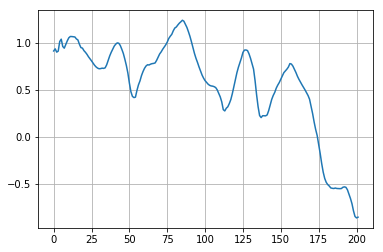

In [235]:
plt.plot(out_dict['loop_feat'][:,0,61])
plt.grid(True)

In [578]:
speaker_info = nu.get_vctk_speaker_info()

In [579]:
speaker_info[speaker_info['accents'] == 'American']

,id,age,gender,accents,region
294,294,33,F,American,San Francisco
297,297,20,F,American,New York
299,299,25,F,American,California
300,300,23,F,American,California
301,301,23,F,American,North Carolina
305,305,19,F,American,Philadelphia
306,306,21,F,American,New York
308,308,18,F,American,Alabama
310,310,21,F,American,Tennessee
311,311,21,M,American,Iowa


## Old Bits

In [549]:
# dev code for adding a dict of meta data for each sample in the loader minibatch
_, fname = os.path.split(d)
spkr_vctk, idx_sentence = fname[:-4].split('_')

vctk_corpus_root = '/home/ubuntu/VCTK-Corpus/'
txt_file = '/home/ubuntu/VCTK-Corpus/txt/p362/p362_409.txt'
txt_file = os.path.join(vctk_corpus_root, 'txt', spkr_vctk, fname[:-4] + '.txt')
f = open(txt_file, 'r')
transcript = f.read()
f.close()

sample_dict = dict()
sample_dict['npz_file'] = d
sample_dict['transcript'] = transcript
sample_dict['idx_sentence'] = int(idx_sentence)

sample_dict

NameError: name 'd' is not defined

In [299]:
feats = np.load('/home/ubuntu/loop/data/vctk/numpy_features/p362_409.npz')

In [620]:
x = feats['phonemes']
#x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
print " ".join(feats['code2phone'][x])

b ah t ih t l uh k s ssil g uh d pau f ao r n eh k s t y ih r


In [621]:
txt_file = '/home/ubuntu/VCTK-Corpus/txt/p362/p362_409.txt'
f = open(txt_file, 'r')
print(f.read())
f.close()

But it looks good for next year.
